<a href="https://colab.research.google.com/github/mariocsp/Project_AI_2023/blob/main/LSTM_And_LSTM_auto_encoder_for_error_binary_classification_using_multilple_feature_The_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Perbedaan utama metode yang kami gunakan dari paper adalah metode pada paper melakukan prediksi terlebih dahulu. Pada paper ,model di train hanya menggunakan data run normal sehingga model dapat memprediksi dengan tepat. Klasifikasi atau deteksi anomaly dilakukan dengan melakukan prediksi pada data, jika error prediksi besar maka data dikategorikan sebagai anomali. Pendekatan yang kami lakukan adalah dengan langsung mengklasifikasi time series tanpa adanya prediksi menggunakan lstm dan encoder-decoder lstm. Untuk kedepannya kami ingin mencoba menggunakan model convlstm, convtran, dan RNN tipe GRU untuk melakukan klasifikasi.

# Menginstall dan Mengimport library yang dibutuhkan

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchmetrics.functional import accuracy
from torch.nn import functional

from tqdm.auto import tqdm
from timeit import default_timer
from torchmetrics import ConfusionMatrix
from torchmetrics.classification import BinaryF1Score, BinaryPrecision
from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix

device = 'cuda' if torch.cuda.is_available() else "cpu"

#Load dan pengolahan data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/Shareddrives/AI/AI2023/hvcm/CCL'
features=['A+IGBT-I', 'A+*IGBT-I', 'B+IGBT-I', 'B+*IGBT-I', 'C+IGBT-I', 'C+*IGBT-I', 'A-FLUX',
         'B-FLUX', 'C-FLUX', 'MOD-V', 'MOD-I', 'CB-I', 'CB-V', 'DV/DT']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Y = np.load(f'{path}_labels.npy', allow_pickle=True)

In [ ]:
df_normalize = pd.read_csv(f"{path}_normalize.csv")
df_normalize.head(10)

,Unnamed: 0.1,Unnamed: 0,timeseries_idx,A+IGBT-I,A+*IGBT-I,B+IGBT-I,B+*IGBT-I,C+IGBT-I,C+*IGBT-I,A-FLUX,B-FLUX,C-FLUX,MOD-V,MOD-I,CB-I,CB-V,DV/DT
0,0,0,0.0,0.625857,0.621531,0.636062,0.615522,0.626562,0.632367,-0.069420,-0.31591,-0.33798,-1.564395,-0.001011,0.045519,0.530564,0.086791
1,1,1,0.0,0.625857,0.624902,0.630980,0.618888,0.626562,0.642766,-0.093835,-0.30370,-0.31357,-1.565259,-0.051549,0.045519,0.518591,-0.003827
2,2,2,0.0,0.629316,0.624902,0.632674,0.618888,0.651726,0.637566,-0.118250,-0.27929,-0.31357,-1.564395,-0.026280,0.015000,0.519548,-0.034032
3,3,3,0.0,0.625857,0.621531,0.632674,0.620571,0.628240,0.632367,-0.106040,-0.30370,-0.32578,-1.563098,-0.051549,-0.046037,0.527212,-0.064237
4,4,4,0.0,0.631046,0.621531,0.636062,0.620571,0.651726,0.634101,-0.093835,-0.29149,-0.33798,-1.563962,-0.001011,0.015000,0.529127,-0.079339
5,5,5,0.0,0.625857,0.621531,0.630980,0.620571,0.624884,0.635833,-0.142660,-0.29149,-0.32578,-1.564395,-0.026280,0.015000,0.518591,0.132098
6,6,6,0.0,0.627587,0.621531,0.630980,0.620571,0.650048,0.635833,-0.106040,-0.26708,-0.32578,-1.563962,-0.026280,0.045519,0.519548,0.011274
7,7,7,0.0,0.629316,0.619845,0.634368,0.622254,0.603076,0.635833,-0.093835,-0.29149,-0.35019,-1.563962,-0.001011,0.015000,0.532001,-0.064237
8,8,8,0.0,0.627587,0.621531,0.634368,0.620571,0.624884,0.641034,-0.081628,-0.27929,-0.30136,-1.563530,0.049528,0.015000,0.524817,-0.079339
9,9,9,0.0,0.629316,0.621531,0.630980,0.622254,0.623206,0.632367,-0.069420,-0.27929,-0.36240,-1.564827,0.024259,0.045519,0.520027,-0.034032


In [ ]:
label_binary = Y[:,1]
label_multiclass = Y[:,2]

df_label = pd.DataFrame([label_binary,label_multiclass]).transpose()
df_label.columns = ['label_binary', 'label_multiclass']

label_binary = df_label['label_binary'] == 'Run'
label_binary = label_binary.astype(np.int32)

df_label['label_binary'] = label_binary
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   label_binary      2057 non-null   int32 
 1   label_multiclass  2057 non-null   object
dtypes: int32(1), object(1)
memory usage: 24.2+ KB


In [ ]:
sequence = []

for timeseries_idx, group in df_normalize.groupby('timeseries_idx'):
  seq_feat = group[features]
  label = df_label['label_binary'][timeseries_idx]
  label = np.float32(label)
  sequence.append([seq_feat,label])

In [ ]:
sequence = np.array(sequence)
train_seq, test_seq = train_test_split(sequence, train_size=0.8, shuffle=True)

<ipython-input-11-6804968c2bb1>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sequence = np.array(sequence)


In [ ]:
test_seq.shape

(412, 2)

In [ ]:
train_seq.shape

(1645, 2)

In [ ]:
train_data = []

for i,(seq,label) in enumerate(train_seq):
  sequ = torch.Tensor(seq.to_numpy())
  labeli = torch.Tensor([label])

  train_data.append((sequ,labeli))

In [ ]:
test_data = []

for i,(seq,label) in enumerate(test_seq):
  sequ = torch.Tensor(seq.to_numpy())
  labeli = torch.Tensor([label])

  test_data.append((sequ,labeli))

In [ ]:
BATCH = 64
train_dataloader = DataLoader(train_data,
                              batch_size = BATCH,
                              shuffle = True,
                              drop_last = True)

test_dataloader = DataLoader(test_data,
                             batch_size = BATCH,
                             shuffle = False)

In [ ]:
train_feature_batch, train_label_batch = next(iter(train_dataloader))


print(f"""

tipe loader train:{type(train_dataloader)}
tipe loader test :{type(test_dataloader)}
jumlah batch train: {len(train_dataloader)}
jumlah batch test: {len(test_dataloader)}
bentuk batch fitur: {train_feature_batch.shape}
bentuk batch label: {train_label_batch.shape}

""")



tipe loader train:<class 'torch.utils.data.dataloader.DataLoader'>
tipe loader test :<class 'torch.utils.data.dataloader.DataLoader'>
jumlah batch train: 25
jumlah batch test: 7
bentuk batch fitur: torch.Size([64, 4500, 14])
bentuk batch label: torch.Size([64, 1])




# Fungsi - Fungsi Untuk Training dan Evaluasi Model

fungsi untuk mentrain model

In [ ]:
def train_loop(model:torch.nn.Module,
               train_dataloader:torch.utils.data.DataLoader,
               loss_fn: torch.nn.modules,
               optimizer: torch.optim.Optimizer,
               device:torch.device = device,
               scheduler=None):

  loss_train = 0
  acc_train = 0
  f1_train = 0
  prec_train = 0


  list_loss_train = []
  list_acc_train = []
  list_f1_train = []
  list_prec_train = []

  model.to(device)

  model.train()

  for batch, (X,y) in enumerate(train_dataloader):

    X = X.to(device)
    y = y.to(device)

    optimizer.zero_grad()

    logit = model(X)
    pred = torch.round(torch.sigmoid(logit))

    loss = loss_fn(logit,y)
    loss_train += loss
    loss.backward()
    optimizer.step()

    acc = accuracy(pred,y,task='binary').item()
    metric_f1 = BinaryF1Score().to(device)
    metric_prec = BinaryPrecision().to(device)
    f1 = metric_f1(pred,y).item()
    prec = metric_prec(pred,y).item()

    acc_train += acc
    f1_train += f1
    prec_train += prec

    list_loss_train.append(loss.item())
    list_acc_train.append(acc)
    list_f1_train.append(f1)
    list_prec_train.append(prec)


    if not scheduler == None:
      scheduler.step()

  pembagi_train = len(train_dataloader)
  loss_train = loss_train/pembagi_train
  acc_train = acc_train/pembagi_train
  f1_train = f1_train/pembagi_train
  prec_train = prec_train/pembagi_train


  dict_metrics = {"model": model.__class__.__name__,
                  "loss": loss_train.item(),
                  "akurasi": acc_train,
                  "F1":f1_train,
                  "presisi":prec_train}


  print(f"""
  __________Train___________
  loss: {loss_train.item():.5f}
  akurasi: {acc_train:.5f}
  F1 :{f1_train:.5f}
  presisi:{prec_train:.5f}
        """)

  return dict_metrics,list_loss_train,list_acc_train,list_f1_train, list_prec_train

fungsi untuk validasi hasil training

In [ ]:
def model_metrics(model:torch.nn.Module,
                  test_dataloader:torch.utils.data.DataLoader,
                  loss_fn: torch.nn.modules):

  model.to(device)
  model.eval()

  list_loss_test = []
  list_acc_test = []
  list_f1_test = []
  list_prec_test = []

  loss_test = 0
  acc_test = 0
  f1_test = 0
  prec_test = 0

  with torch.inference_mode():

    for batch, (X,y) in enumerate(test_dataloader):
      X = X.to(device)
      y = y.to(device)

      logit = model(X)
      loss = loss_fn(logit,y)

      loss_test += loss
      pred = torch.round(torch.sigmoid(logit))

      acc = accuracy(pred,y,task='binary').item()
      metric_f1 = BinaryF1Score().to(device)
      metric_prec = BinaryPrecision().to(device)
      f1 = metric_f1(pred,y).item()
      prec = metric_prec(pred,y).item()

      acc_test += acc
      f1_test += f1
      prec_test += prec

      list_loss_test.append(loss.item())
      list_acc_test.append(acc)
      list_f1_test.append(f1)
      list_prec_test.append(prec)

    pembagi_test = len(test_dataloader)

    loss_test = loss_test/pembagi_test
    acc_test = acc_test/pembagi_test
    f1_test = f1_test/pembagi_test
    prec_test = prec_test/pembagi_test


  dict_metrics = {"model": model.__class__.__name__,
                  "loss": loss_test.item(),
                  "akurasi": acc_test,
                  "F1" :f1_test,
                  'presisi':prec_test}

  print(f"""

  _________Test______________
  loss: {loss_test.item():.5f}
  akurasi: {acc_test:.5f}
  F1 :{f1_test:.5f}
  presisi:{prec_test:.5f}
        """)

  return dict_metrics, list_loss_test, list_acc_test,list_f1_test, list_prec_test

fungsi untuk visualisasi hasil training dan validasi

In [ ]:
def manual_tensorboard(dict_info:dict):
  fig, axs = plt.subplots(3,3)
  fig.set_figheight(12)
  fig.set_figwidth(12)

  for j,i in enumerate(dict_info):
    value = dict_info[i]
    x = np.linspace(0,100,len(value))
    fig.add_subplot(3, 3, j+ 1 )
    plt.plot(x,value)
    plt.xlabel('Time (s)')
    plt.title(i)
    plt.xticks([])
    plt.yticks([])
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

  fig.show()

  return True


fungsi untuk menampilkan confusion matrix

In [ ]:
def confusion_metric(model, dataloader):
  y_preds = []
  labels = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(dataloader, desc="Making predictions"):
      X, y = X.to(device), y.to(device)
      y_logit = model(X)
      y_pred = torch.round(torch.sigmoid(y_logit))
      y_preds.append(y_pred.cpu())
      labels.append(y.cpu())

    y_pred_tensor = torch.cat(y_preds)
    labels = torch.cat(labels)

    confmat = ConfusionMatrix(num_classes=2, task='binary')
    confmat_tensor = confmat(preds=y_pred_tensor,
                         target=labels)
    # 3. Plot the confusion matrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
        figsize=(10, 7)
        );

    return True


# Training model 0

Definisikan model

In [ ]:
class Classification_modelv0(nn.Module):
  def __init__(self,input_dim,nodes,output_dim,layer):
    super().__init__()
    self.nodes = nodes
    self.lstm = nn.LSTM(
        input_size = input_dim,
        hidden_size = nodes,
        num_layers = layer,
        batch_first = True,
        )

    self.classifier = nn.Linear(nodes,output_dim)


  def forward(self,x):
    self.lstm.flatten_parameters()
    _,(hidden,_) = self.lstm(x)

    out = hidden[-1]

    return self.classifier(out)

inisialisasi model

In [ ]:
torch.manual_seed(21)
model_0 = Classification_modelv0(input_dim = 14,nodes = 128,
                                 output_dim = 1, layer =  3)
print(model_0)

Classification_modelv0(
  (lstm): LSTM(14, 128, num_layers=3, batch_first=True)
  (classifier): Linear(in_features=128, out_features=1, bias=True)
)


mengamati bentuk keluaran model

In [ ]:
with torch.inference_mode():
  dummy_image = torch.rand([2,28,14])
  y_pred = model_0(dummy_image)

print(y_pred.shape)
print(y_pred)

torch.Size([2, 1])
tensor([[-0.0611],
        [-0.0606]])


mendefinisikan loss function, otimizer, dan scheduler jika dibutuhkan

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params = model_0.parameters())


print(type(loss_fn))
print(type(optimizer))


<class 'torch.nn.modules.loss.BCEWithLogitsLoss'>
<class 'torch.optim.adamw.AdamW'>


proses training

In [ ]:
epochs = 15

dict_info = {'loss_train':[],
             'acc_train':[],
             'F1_train':[],
             'prec_train':[],
             'loss_test':[],
             'acc_test':[],
             'F1_test':[],
             'prec_test':[]}

for epoch in range(epochs+1):
  print(f"epoch--{epoch}\n________")
  log_train,l,a,F1,p = train_loop(model_0,
                         train_dataloader,
                         loss_fn,
                         optimizer,
                         device)

  dict_info['loss_train'] = dict_info['loss_train'] + l
  dict_info['acc_train'] = dict_info['acc_train'] + a
  dict_info['F1_train'] = dict_info['F1_train'] + F1
  dict_info['prec_train'] = dict_info['prec_train'] + p

  if epoch%(epochs//10) == 0:
    log_test,lt,at,F1t,pt = model_metrics(model_0,test_dataloader,loss_fn)

    dict_info['loss_test'] = dict_info['loss_test'] + lt
    dict_info['acc_test'] = dict_info['acc_test'] + at
    dict_info['F1_test'] = dict_info['F1_test'] + F1t
    dict_info['prec_test'] = dict_info['prec_test'] + pt



epoch--0
________

  __________Train___________
  loss: 0.45510
  akurasi: 0.82625
  F1 :0.88275
  presisi:0.82260
        


  _________Test______________
  loss: 0.40410
  akurasi: 0.86224
  F1 :0.92485
  presisi:0.86171
        
epoch--1
________

  __________Train___________
  loss: 0.37085
  akurasi: 0.88125
  F1 :0.93432
  presisi:0.87736
        


  _________Test______________
  loss: 0.37371
  akurasi: 0.87564
  F1 :0.93171
  presisi:0.87379
        
epoch--2
________

  __________Train___________
  loss: 0.34623
  akurasi: 0.88875
  F1 :0.93785
  presisi:0.88396
        


  _________Test______________
  loss: 0.37389
  akurasi: 0.87564
  F1 :0.93171
  presisi:0.87379
        
epoch--3
________

  __________Train___________
  loss: 0.35589
  akurasi: 0.88500
  F1 :0.93555
  presisi:0.88165
        


  _________Test______________
  loss: 0.37122
  akurasi: 0.87564
  F1 :0.93171
  presisi:0.87379
        
epoch--4
________

  __________Train___________
  loss: 0.36326
  akuras

# Evaluasi Model 0

True

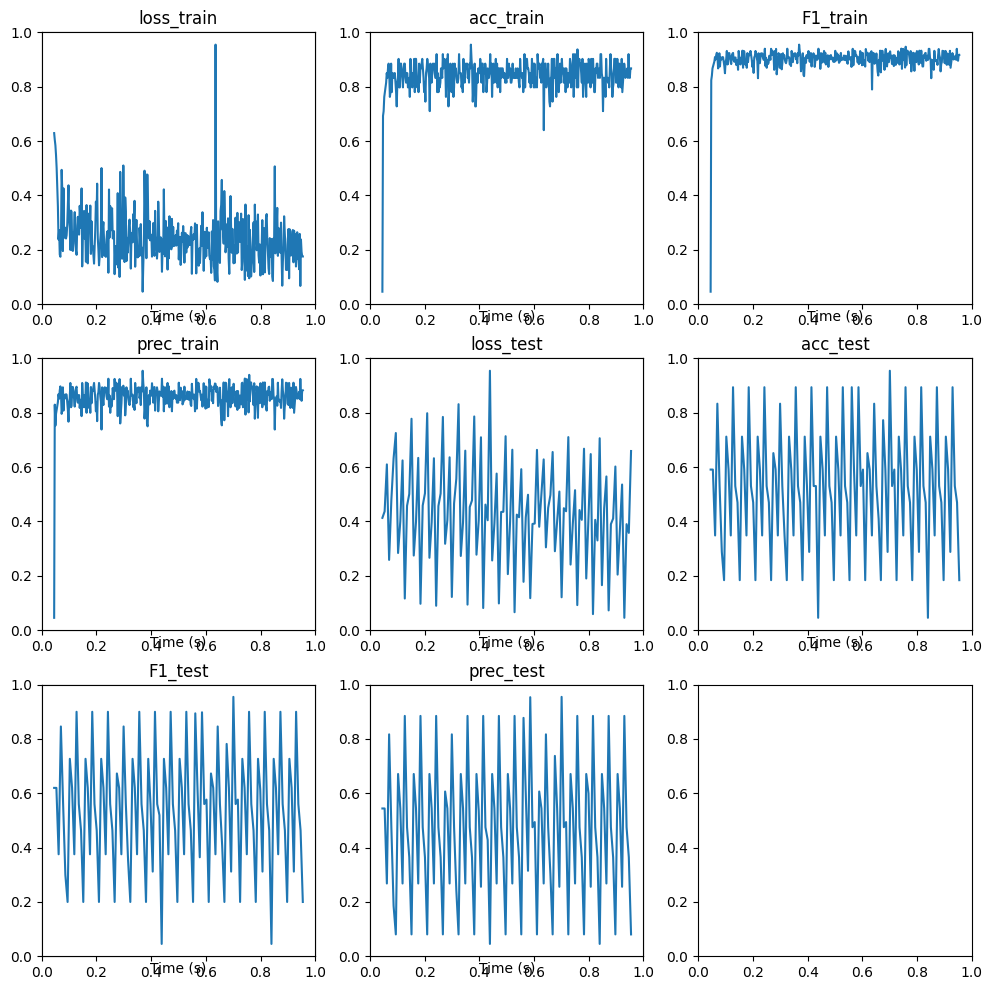

In [ ]:
manual_tensorboard(dict_info)

In [ ]:
"""
torch.save(model_0.state_dict(),path + ".pth")
"""

print('run this only when you get good result')

run this only when you get good result


In [ ]:
model_0_inf = Classification_modelv0(input_dim = 14,nodes = 128,
                                 output_dim = 1, layer =  3)

state0 = torch.load(path + ".pth")
model_0_inf.load_state_dict(state0)


<All keys matched successfully>

In [ ]:
log_train

{'model': 'Classification_modelv0',
 'loss': 0.3066219687461853,
 'akurasi': 0.888125,
 'F1': 0.937597324848175,
 'presisi': 0.883154947757721}

In [ ]:
log_test

{'model': 'Classification_modelv0',
 'loss': 0.3270739018917084,
 'akurasi': 0.8734056098120553,
 'F1': 0.9303632123129708,
 'presisi': 0.8734046987124852}

Making predictions:   0%|          | 0/25 [00:00<?, ?it/s]

True

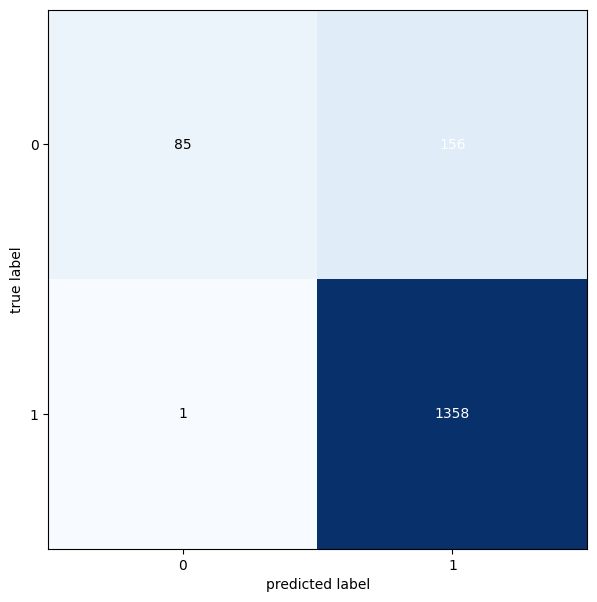

In [ ]:
confusion_metric(model_0_inf,train_dataloader)

Making predictions:   0%|          | 0/7 [00:00<?, ?it/s]

True

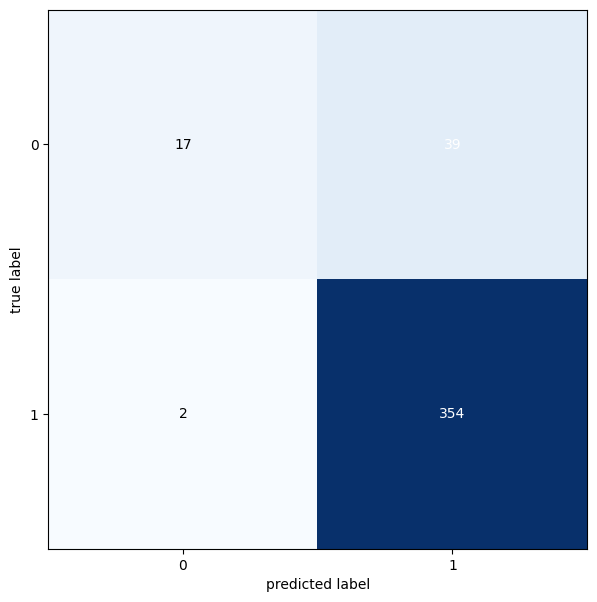

In [ ]:
confusion_metric(model_0_inf,test_dataloader)

# Load dan olah dataset untuk menyamakan frekuensi data

In [ ]:
X = np.load(f'{path}.npy')

In [ ]:
np.random.seed(22)
Y_bin = label_binary.to_numpy()
fault_indices, normal_indices = np.where(Y_bin == 0)[0], np.where(Y_bin == 1)[0]

normal_indices = np.random.choice(normal_indices,size = 500)

Xnormal, Xanomaly = X[normal_indices,:,:], X[fault_indices,:,:]
Ynormal, Yanomaly = Y_bin[normal_indices], Y_bin[fault_indices]

In [ ]:
np.random.seed(22)
X_freq = np.concatenate((Xnormal,Xanomaly))
Y_freq = np.concatenate((Ynormal,Yanomaly))

X_train, X_test, y_train, y_test = train_test_split(X_freq, Y_freq, test_size=0.25, random_state=42)

In [ ]:
train_freq = []
for seq,label in zip(X_train,y_train):
  train_freq.append((seq,np.float32([label])))


In [ ]:
test_freq = []
for seq,label in zip(X_test,y_test):
  test_freq.append((seq,np.float32([label])))

In [ ]:
print(len(train_freq),len(test_freq))

603 202


In [ ]:
BATCH = 32
train_freq_dataloader = DataLoader(train_freq,
                        batch_size = BATCH,
                        shuffle = True,
                        drop_last = True)

test_freq_dataloader = DataLoader(test_freq,
                             batch_size = BATCH,
                             shuffle = False,
                              drop_last = True)

# Training model_1 (menyeimbangkan frekuensi run dan fault, lalu mencobanya pada model encoder dan decoder)

In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True)


    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True)

  def forward(self, x):

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n

In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, 1)

  def forward(self, x):

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)


    return self.output_layer(x).squeeze(dim = 0)

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
torch.manual_seed(22)
model_1 =  RecurrentAutoencoder(seq_len= 4500, n_features = 14,embedding_dim=128)
model_1

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(14, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [ ]:
dummy_image = torch.rand([2,4500,14])
y_pred = model_1(dummy_image.to(device))

print(y_pred.shape)
print(y_pred)

torch.Size([2, 1])
tensor([[-0.0511],
        [-0.0512]], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [ ]:
loss_fn1 = nn.BCEWithLogitsLoss()
optimizer1 = torch.optim.Adam(params = model_1.parameters(),lr = 0.0001)#,weight_decay = 0.0001)
scheduler1 = torch.optim.lr_scheduler.LinearLR(optimizer1,
                                               start_factor=0.3333333333333333,
                                               end_factor=1.0, total_iters=5,
                                               last_epoch=- 1, verbose=False)

print(type(loss_fn1))
print(type(optimizer1))
print(type(scheduler1))

<class 'torch.nn.modules.loss.BCEWithLogitsLoss'>
<class 'torch.optim.adam.Adam'>
<class 'torch.optim.lr_scheduler.LinearLR'>


In [ ]:
epochs = 100

dict_info = {'loss_train':[],
             'acc_train':[],
             'F1_train':[],
             'prec_train':[],
             'loss_test':[],
             'acc_test':[],
             'F1_test':[],
             'prec_test':[]}

for epoch in range(epochs+1):
  print(f"epoch--{epoch}\n________")
  log_train,l,a,F1,p = train_loop(model_1,
                         train_freq_dataloader,
                         loss_fn1,
                         optimizer1,
                         device,
                         scheduler1)

  dict_info['loss_train'] = dict_info['loss_train'] + l
  dict_info['acc_train'] = dict_info['acc_train'] + a
  dict_info['F1_train'] = dict_info['F1_train'] + F1
  dict_info['prec_train'] = dict_info['prec_train'] + p

  if epoch%(epochs//10) == 0:
    log_test,lt,at,F1t,pt = model_metrics(model_1,test_freq_dataloader,loss_fn1)

    dict_info['loss_test'] = dict_info['loss_test'] + lt
    dict_info['acc_test'] = dict_info['acc_test'] + at
    dict_info['F1_test'] = dict_info['F1_test'] + F1t
    dict_info['prec_test'] = dict_info['prec_test'] + pt



epoch--0
________

  __________Train___________
  loss: 0.69193
  akurasi: 0.50521
  F1 :0.41732
  presisi:0.34732
        


  _________Test______________
  loss: 0.68221
  akurasi: 0.61458
  F1 :0.75380
  presisi:0.61290
        
epoch--1
________

  __________Train___________
  loss: 0.66878
  akurasi: 0.63194
  F1 :0.76831
  presisi:0.63138
        
epoch--2
________

  __________Train___________
  loss: 0.66074
  akurasi: 0.62847
  F1 :0.76601
  presisi:0.62847
        
epoch--3
________

  __________Train___________
  loss: 0.66285
  akurasi: 0.62500
  F1 :0.76507
  presisi:0.62500
        
epoch--4
________

  __________Train___________
  loss: 0.65807
  akurasi: 0.62674
  F1 :0.76715
  presisi:0.62674
        
epoch--5
________

  __________Train___________
  loss: 0.65392
  akurasi: 0.62847
  F1 :0.76975
  presisi:0.62774
        
epoch--6
________

  __________Train___________
  loss: 0.65965
  akurasi: 0.61806
  F1 :0.76142
  presisi:0.61806
        
epoch--7
________

  ___

# Evaluasi Model_1

True

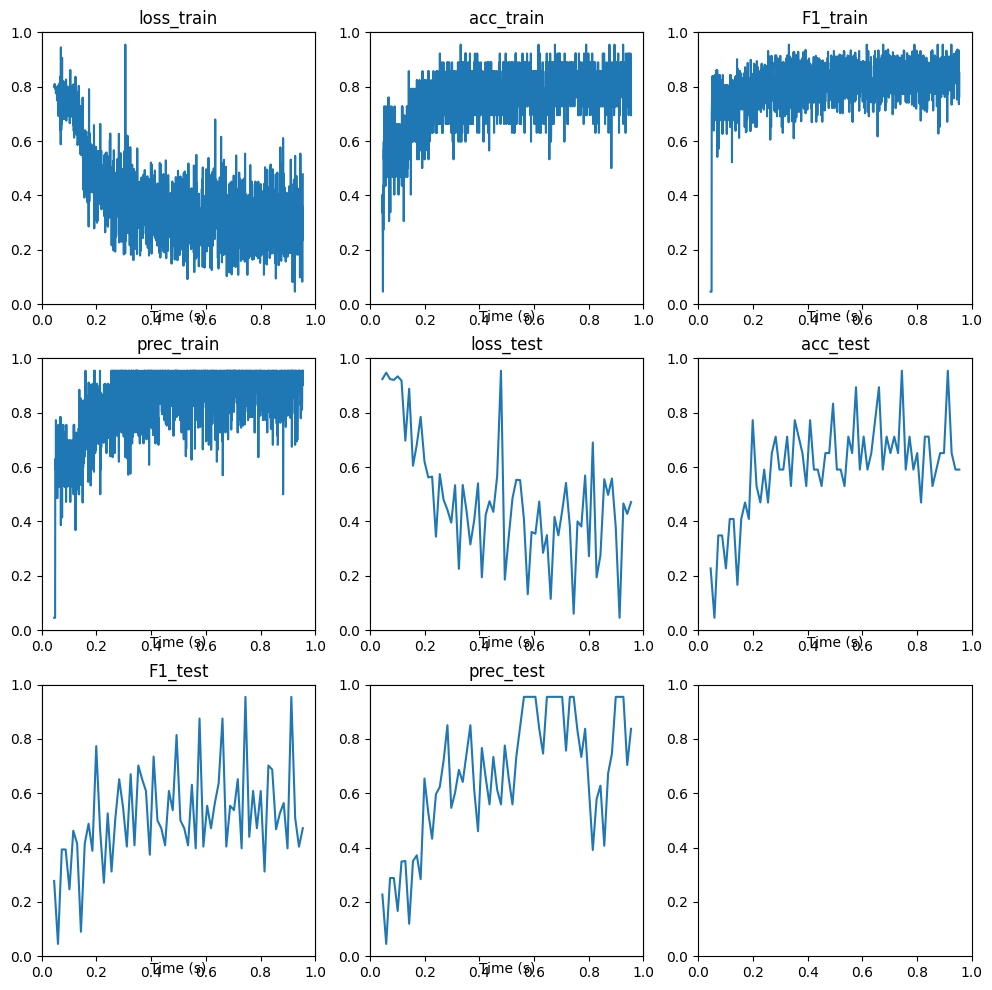

In [ ]:
manual_tensorboard(dict_info)

In [ ]:
log_test

{'model': 'RecurrentAutoencoder',
 'loss': 0.35694849491119385,
 'akurasi': 0.828125,
 'F1': 0.8373995920022329,
 'presisi': 0.9488425950209299}

In [ ]:
log_train

{'model': 'RecurrentAutoencoder',
 'loss': 0.25558775663375854,
 'akurasi': 0.8663194444444444,
 'F1': 0.8851728505558438,
 'presisi': 0.9176825185616811}

In [ ]:
"""
torch.save(model_1.state_dict(),path + "1.pth")
"""

print('run only when you get good result')

run only when you get good result


In [ ]:
model_1_inf = RecurrentAutoencoder(seq_len= 4500, n_features = 14,embedding_dim=128)

state = torch.load(path + "1.pth")
model_1_inf.load_state_dict(state)

<All keys matched successfully>

Making predictions:   0%|          | 0/18 [00:00<?, ?it/s]

True

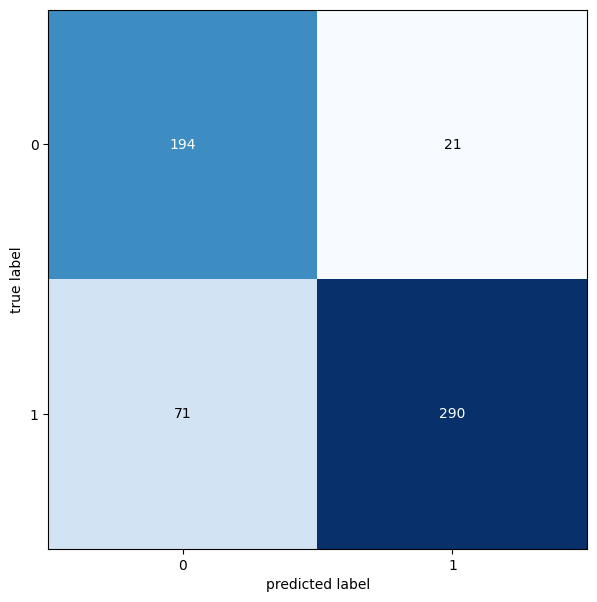

In [ ]:
confusion_metric(model_1_inf,train_freq_dataloader)

Making predictions:   0%|          | 0/6 [00:00<?, ?it/s]

True

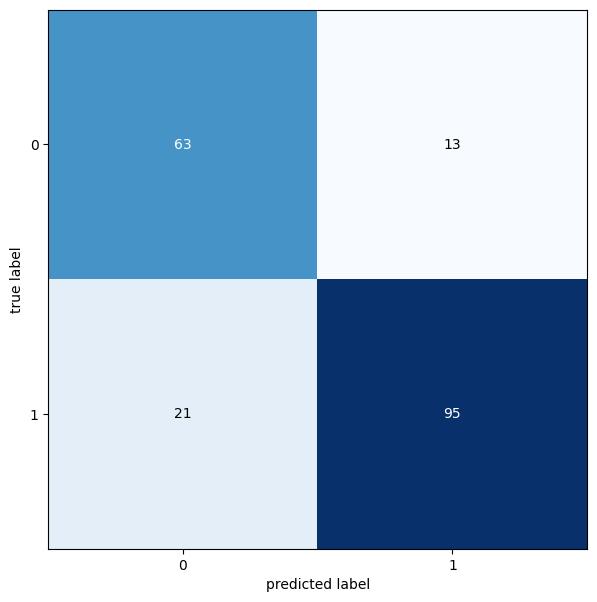

In [ ]:
confusion_metric(model_1_inf,test_freq_dataloader)

# Training Model 2 (model 0 namun menggunakan data dengan frekuensi run dan fault yang berimbang dan menggunakan scheduler saat training)

In [ ]:
torch.manual_seed(21)
model_2 = Classification_modelv0(input_dim = 14,nodes = 128,
                                 output_dim = 1, layer =  3)
print(model_2)

Classification_modelv0(
  (lstm): LSTM(14, 128, num_layers=3, batch_first=True)
  (classifier): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
loss_fn2 = nn.BCEWithLogitsLoss()
optimizer2 = torch.optim.Adam(params = model_2.parameters(),lr = 0.0001)#,weight_decay = 0.0001)
scheduler2 = torch.optim.lr_scheduler.LinearLR(optimizer2,
                                               start_factor=0.3333333333333333,
                                               end_factor=1.0, total_iters=5,
                                               last_epoch=- 1, verbose=False)

print(type(loss_fn2))
print(type(optimizer2))
print(type(scheduler2))

<class 'torch.nn.modules.loss.BCEWithLogitsLoss'>
<class 'torch.optim.adam.Adam'>
<class 'torch.optim.lr_scheduler.LinearLR'>


In [ ]:
epochs = 100

dict_info = {'loss_train':[],
             'acc_train':[],
             'F1_train':[],
             'prec_train':[],
             'loss_test':[],
             'acc_test':[],
             'F1_test':[],
             'prec_test':[]}

for epoch in range(epochs+1):
  print(f"epoch--{epoch}\n________")
  log_train,l,a,F1,p = train_loop(model_2,
                         train_freq_dataloader,
                         loss_fn2,
                         optimizer2,
                         device,
                         scheduler2)

  dict_info['loss_train'] = dict_info['loss_train'] + l
  dict_info['acc_train'] = dict_info['acc_train'] + a
  dict_info['F1_train'] = dict_info['F1_train'] + F1
  dict_info['prec_train'] = dict_info['prec_train'] + p

  if epoch%(epochs//10) == 0:
    log_test,lt,at,F1t,pt = model_metrics(model_2,test_freq_dataloader,loss_fn2)

    dict_info['loss_test'] = dict_info['loss_test'] + lt
    dict_info['acc_test'] = dict_info['acc_test'] + at
    dict_info['F1_test'] = dict_info['F1_test'] + F1t
    dict_info['prec_test'] = dict_info['prec_test'] + pt



epoch--0
________

  __________Train___________
  loss: 0.68976
  akurasi: 0.53299
  F1 :0.42723
  presisi:0.36319
        


  _________Test______________
  loss: 0.67507
  akurasi: 0.64062
  F1 :0.77031
  presisi:0.62864
        
epoch--1
________

  __________Train___________
  loss: 0.65927
  akurasi: 0.65799
  F1 :0.77784
  presisi:0.64274
        
epoch--2
________

  __________Train___________
  loss: 0.62362
  akurasi: 0.66840
  F1 :0.78768
  presisi:0.65439
        
epoch--3
________

  __________Train___________
  loss: 0.60297
  akurasi: 0.68229
  F1 :0.79579
  presisi:0.66537
        
epoch--4
________

  __________Train___________
  loss: 0.57506
  akurasi: 0.72569
  F1 :0.81764
  presisi:0.69712
        
epoch--5
________

  __________Train___________
  loss: 0.54149
  akurasi: 0.73611
  F1 :0.81378
  presisi:0.72128
        
epoch--6
________

  __________Train___________
  loss: 0.49172
  akurasi: 0.70139
  F1 :0.77962
  presisi:0.72513
        
epoch--7
________

  ___

# Evaluasi Model_2

In [ ]:
log_train

{'model': 'Classification_modelv0',
 'loss': 0.2869645655155182,
 'akurasi': 0.84375,
 'F1': 0.8696391648716397,
 'presisi': 0.8870282570521036}

In [ ]:
log_test

{'model': 'Classification_modelv0',
 'loss': 0.3056715130805969,
 'akurasi': 0.828125,
 'F1': 0.8324626088142395,
 'presisi': 0.9779202242692312}

In [ ]:
"""
torch.save(model_2.state_dict(),path + "2.pth")
"""

print('run only when you get good result')

run only when you get good result


In [ ]:
model_2_inf = Classification_modelv0(input_dim = 14,nodes = 128,
                                 output_dim = 1, layer =  3)

state2 = torch.load(path + "2.pth")
model_2_inf.load_state_dict(state2)


<All keys matched successfully>

True

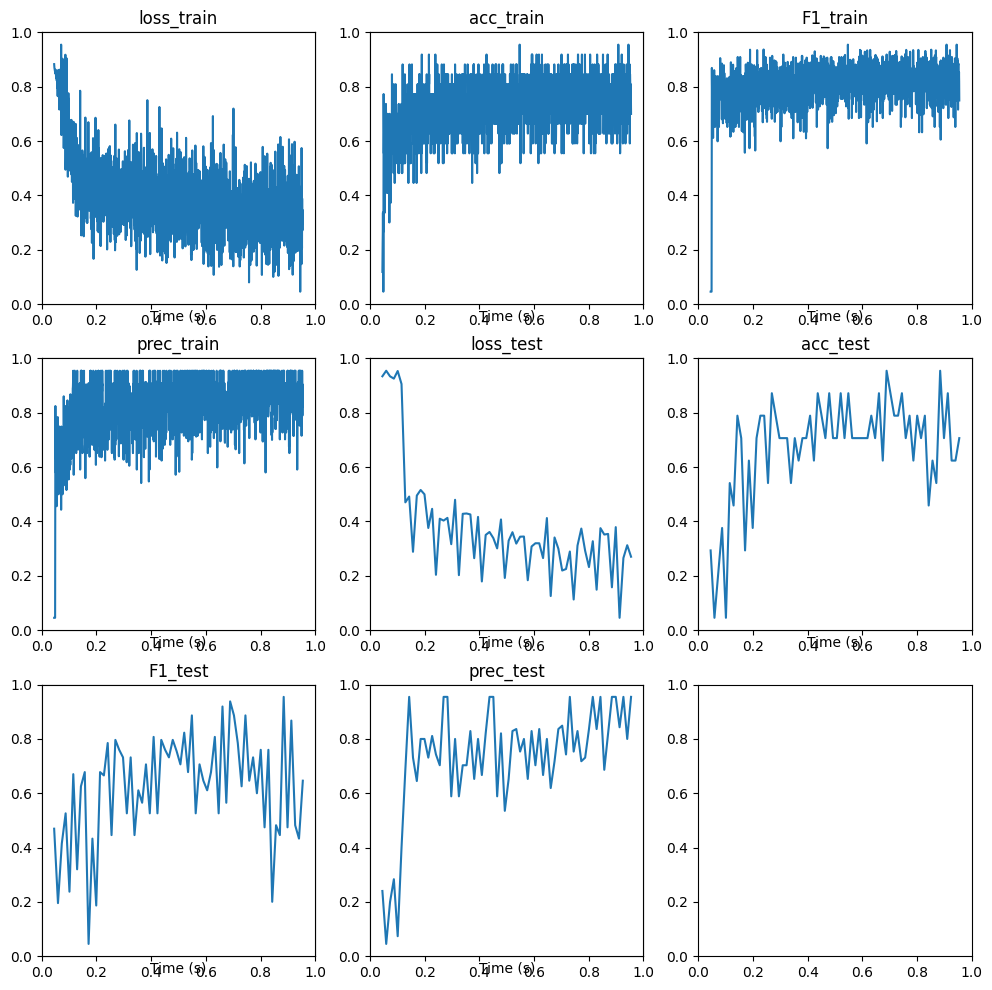

In [ ]:
manual_tensorboard(dict_info)

Making predictions:   0%|          | 0/18 [00:00<?, ?it/s]

True

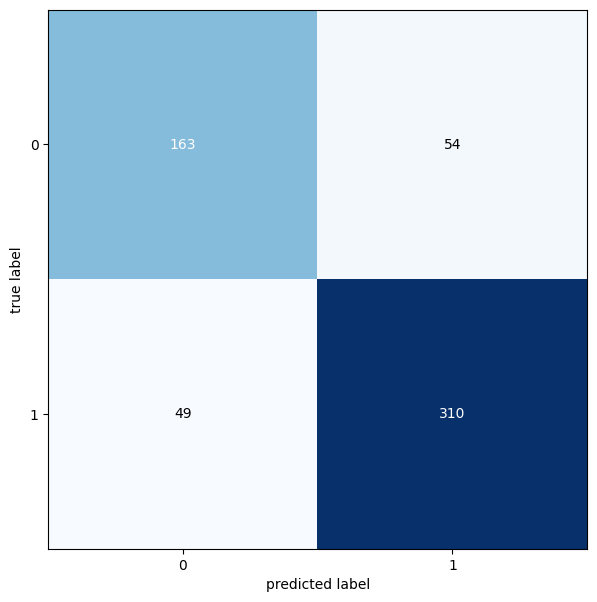

In [ ]:
confusion_metric(model_2_inf,train_freq_dataloader)

Making predictions:   0%|          | 0/6 [00:00<?, ?it/s]

True

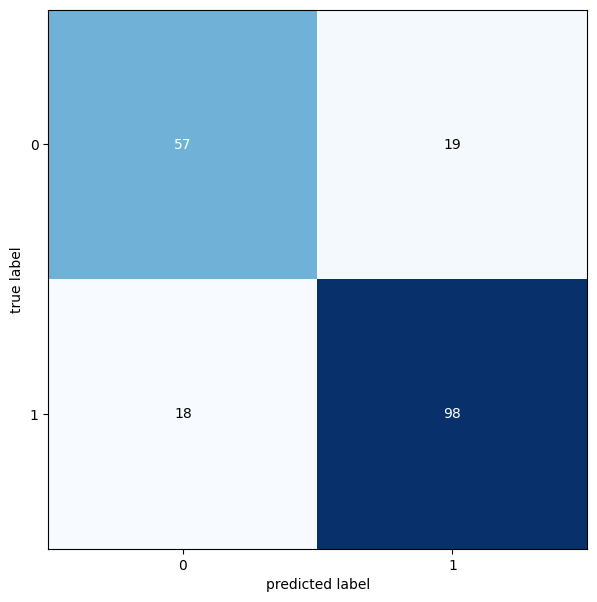

In [ ]:
confusion_metric(model_2_inf,test_freq_dataloader)

# Training model_3(Model 0 namun di training menggunakan scheduler)

In [ ]:
torch.manual_seed(21)
model_3 = Classification_modelv0(input_dim = 14,nodes = 128,
                                 output_dim = 1, layer =  3)
print(model_3)

Classification_modelv0(
  (lstm): LSTM(14, 128, num_layers=3, batch_first=True)
  (classifier): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
loss_fn3 = nn.BCEWithLogitsLoss()
optimizer3 = torch.optim.Adam(params = model_3.parameters(),lr = 0.0001)#,weight_decay = 0.0001)
scheduler3 = torch.optim.lr_scheduler.LinearLR(optimizer3,
                                               start_factor=0.3333333333333333,
                                               end_factor=1.0, total_iters=10,
                                               last_epoch=- 1, verbose=False)

print(type(loss_fn3))
print(type(optimizer3))
print(type(scheduler3))

<class 'torch.nn.modules.loss.BCEWithLogitsLoss'>
<class 'torch.optim.adam.Adam'>
<class 'torch.optim.lr_scheduler.LinearLR'>


In [ ]:
epochs = 30

dict_info = {'loss_train':[],
             'acc_train':[],
             'F1_train':[],
             'prec_train':[],
             'loss_test':[],
             'acc_test':[],
             'F1_test':[],
             'prec_test':[]}

for epoch in range(epochs+1):
  print(f"epoch--{epoch}\n________")
  log_train,l,a,F1,p = train_loop(model_3,
                         train_dataloader,
                         loss_fn3,
                         optimizer3,
                         device,
                         scheduler3)

  dict_info['loss_train'] = dict_info['loss_train'] + l
  dict_info['acc_train'] = dict_info['acc_train'] + a
  dict_info['F1_train'] = dict_info['F1_train'] + F1
  dict_info['prec_train'] = dict_info['prec_train'] + p

  if epoch%(epochs//10) == 0:
    log_test,lt,at,F1t,pt = model_metrics(model_3,test_dataloader,loss_fn3)

    dict_info['loss_test'] = dict_info['loss_test'] + lt
    dict_info['acc_test'] = dict_info['acc_test'] + at
    dict_info['F1_test'] = dict_info['F1_test'] + F1t
    dict_info['prec_test'] = dict_info['prec_test'] + pt



epoch--0
________

  __________Train___________
  loss: 0.68929
  akurasi: 0.50313
  F1 :0.49167
  presisi:0.51440
        


  _________Test______________
  loss: 0.65022
  akurasi: 0.85778
  F1 :0.92262
  presisi:0.85778
        
epoch--1
________

  __________Train___________
  loss: 0.55795
  akurasi: 0.85250
  F1 :0.91959
  presisi:0.85243
        
epoch--2
________

  __________Train___________
  loss: 0.40483
  akurasi: 0.85000
  F1 :0.91814
  presisi:0.84986
        
epoch--3
________

  __________Train___________
  loss: 0.38876
  akurasi: 0.85562
  F1 :0.92101
  presisi:0.85445
        


  _________Test______________
  loss: 0.39513
  akurasi: 0.85778
  F1 :0.92262
  presisi:0.85778
        
epoch--4
________

  __________Train___________
  loss: 0.38399
  akurasi: 0.86062
  F1 :0.92344
  presisi:0.85876
        
epoch--5
________

  __________Train___________
  loss: 0.37499
  akurasi: 0.86438
  F1 :0.92541
  presisi:0.86233
        
epoch--6
________

  __________Train____

In [ ]:
log_train

{'model': 'Classification_modelv0',
 'loss': 0.25531092286109924,
 'akurasi': 0.899375,
 'F1': 0.9429769062995911,
 'presisi': 0.9007667875289918}

In [ ]:
log_test

{'model': 'Classification_modelv0',
 'loss': 0.2956942915916443,
 'akurasi': 0.8890306098120553,
 'F1': 0.9367495775222778,
 'presisi': 0.9024659224918911}

In [ ]:
"""
torch.save(model_3.state_dict(),path + "3.pth")
"""

print('run this only when you get good result')

run this only when you get good result


In [ ]:
model_3_inf = Classification_modelv0(input_dim = 14,nodes = 128,
                                 output_dim = 1, layer =  3)

state3 = torch.load(path + ".pth")
model_3_inf.load_state_dict(state3)


<All keys matched successfully>

True

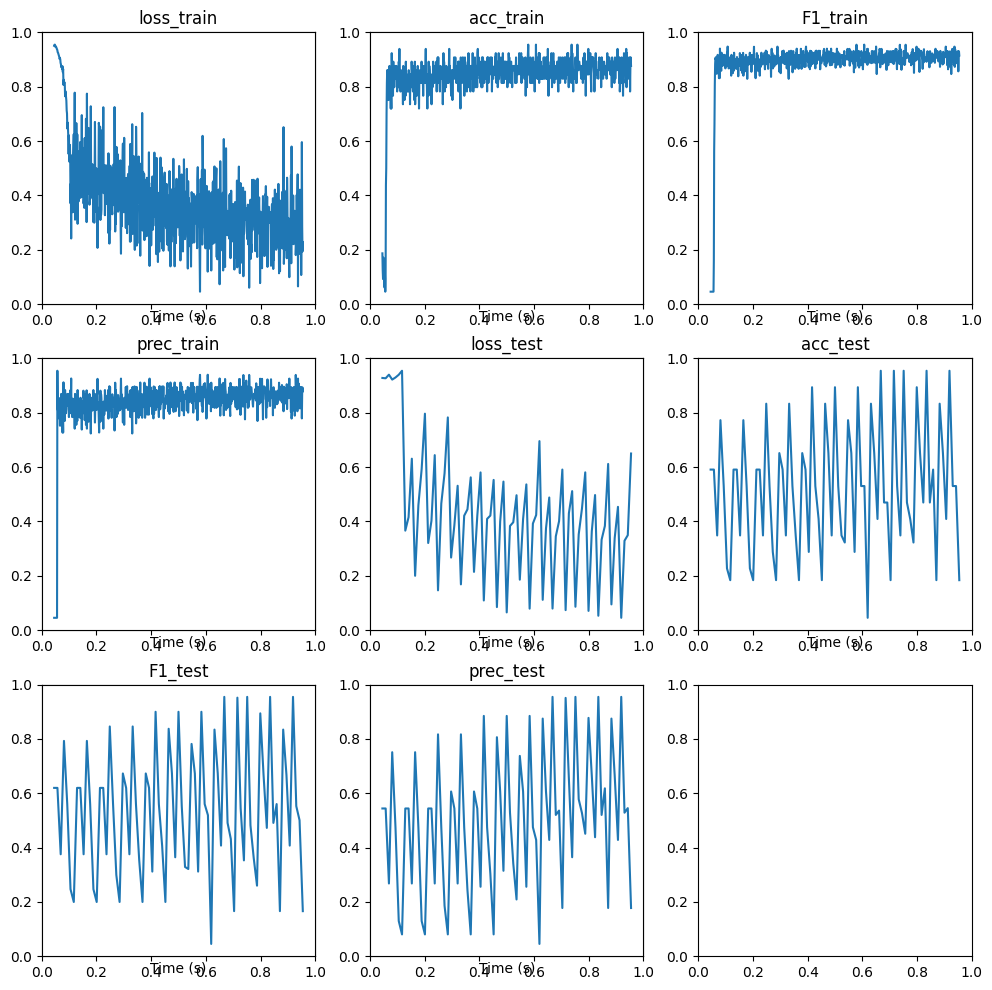

In [ ]:
manual_tensorboard(dict_info)

Making predictions:   0%|          | 0/25 [00:00<?, ?it/s]

True

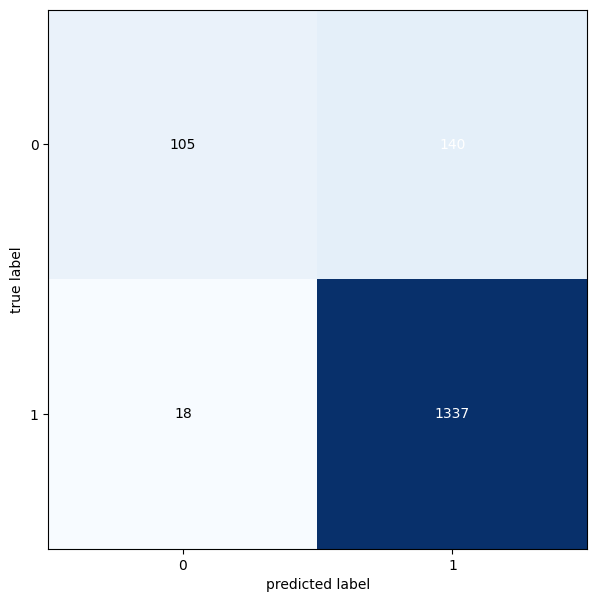

In [ ]:
confusion_metric(model_3,train_dataloader)

Making predictions:   0%|          | 0/7 [00:00<?, ?it/s]

True

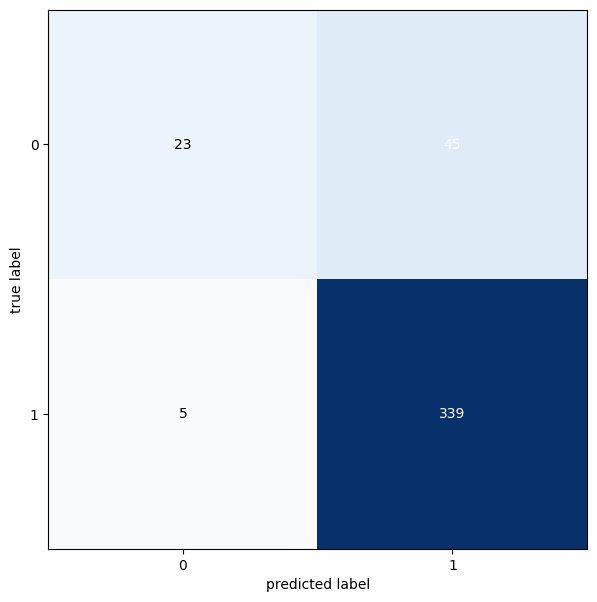

In [ ]:
confusion_metric(model_3,test_dataloader)